This notebook explores the **unusually high churn** pattern exhibited by developers; from the granularity of both files and functions. 

As prerequisites, a table of commits sorted by data such as generated [here](https://colab.research.google.com/drive/1KVCVwkmQUdJb2pS2r8p9Gyi0t7CYzHkV) and a static callgraph (in the form of a graphviz .dot file), generated by analysing a repository's source directory, are assumed. 

We start the exploration from a *file* level.


As [this pluralsight's book on development patterns touches on](https://www.pluralsight.com/content/dam/pluralsight2/landing-pages/offers/flow/pdf/Pluralsight_20Patterns_ebook.pdf). To recognize unusual churn levels, a team leader needs to be familiar with "normal churn levels" exhibitted by each individual in their team, spotting periods of struggle, and acting accordingly. 

One way to do this, is with a visual that contrasts between productive throughput and code churn. 

We start with this, but make a couple of admittedly simplistic assumptions: 


*   Productive throughput, from one commit to another, is assumed to be the number of additions made---as extracted from the commits's diff.
*   Code churn is assumed to be the number of deletions.



With those assumptions, we proceed to generate the visual as follows:

In [1]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/HPCL/ideas-uo.git

Cloning into 'ideas-uo'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 495 (delta 29), reused 47 (delta 18), pack-reused 424
Receiving objects: 100% (495/495), 15.07 MiB | 1.24 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [3]:
!pwd

/content


In [4]:
!ls ideas-uo/data/high_churn_data/

callgraph.dot	    lammps_sorted_commits.csv
clean_unmangle.dot  lamps_unmangle.dot


In [48]:
import pandas as pd 
lammps_sorted_commits = pd.read_csv("/content/ideas-uo/data/high_churn_data/lammps_sorted_commits.csv").drop(columns=['Unnamed: 0'])

In [6]:
lammps_sorted_commits.head()

,year,month,day,doy,dow,full_date,files,files_dict,message,person,locc,locc+,locc-,sha
0,2006,9,21,264,Thursday,2006-09-21 16:22:34+00:00,['a/doc/2001/README.html b/doc/2001/README.htm...,{'a/doc/2001/README.html b/doc/2001/README.htm...,git-svn-id: svn://svn.icms.temple.edu/lamm...,b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...,49081,49081,0,b'b93436e48b86c3212ea293db8343b74429bc4ac1'
1,2006,9,26,269,Tuesday,2006-09-26 15:44:28+00:00,['a/doc/Section_errors.html b/doc/Section_erro...,{'a/doc/Section_errors.html b/doc/Section_erro...,git-svn-id: svn://svn.icms.temple.edu/lamm...,b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...,3,2,1,b'd66323cfcc6d6a439c7f237d2738fc1792ce1f2f'
2,2006,9,26,269,Tuesday,2006-09-26 15:43:58+00:00,['a/doc/Section_errors.txt b/doc/Section_error...,{'a/doc/Section_errors.txt b/doc/Section_error...,git-svn-id: svn://svn.icms.temple.edu/lamm...,b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...,3,2,1,b'2f73f5a9e4de66c1dc7df39a1c63a770a13c669e'
3,2006,9,26,269,Tuesday,2006-09-26 15:30:56+00:00,['a/doc/Manual.html b/doc/Manual.html'],"{'a/doc/Manual.html b/doc/Manual.html': [8, 4,...",git-svn-id: svn://svn.icms.temple.edu/lamm...,b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...,8,4,4,b'58f4781ab3f0fe609e542b6c73b39111efd2ceba'
4,2006,9,27,270,Wednesday,2006-09-27 19:51:49+00:00,"['a/tools/Makefile b/tools/Makefile', 'a/tools...","{'a/tools/Makefile b/tools/Makefile': [43, 43,...",git-svn-id: svn://svn.icms.temple.edu/lamm...,b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...,132239,132239,0,b'60c7f745b9b71f08394f3807afc52f56f8b46055'


In [7]:
def sorted_people_commits(year=None, month=None, sorted=True):
  """return list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows. Filter out users with no commits

  param  : year and month as time window from which to search 
  
  """
  people_commits = []
  seen = {}
  for i in range(len(lammps_sorted_commits['person'].index)):
    try:
      throw_away = seen[lammps_sorted_commits['person'][i]]
      if throw_away == 1:
        continue 
    except KeyError:
      seen[lammps_sorted_commits['person'][i]] = 1
      comm_p_year  = None  
      comm_p_year_month = pd.DataFrame({'m_dud' : []}) 
      comm_p_month = pd.DataFrame({'m_dud' : []}) 
      if year is None:
        comm_p_year = True 
        if not (month is None): 
          comm_p_month = (lammps_sorted_commits['month'] == month)
      else:
        comm_p_year = (lammps_sorted_commits['year'] == year)
        if not (month is None):    
          comm_p_year_month = (lammps_sorted_commits['year'] == year) & (lammps_sorted_commits['month'] == month)
      commits_by_p = None
      if not (comm_p_year_month.empty):
        commits_by_p = lammps_sorted_commits[comm_p_year_month & (lammps_sorted_commits['person'] == lammps_sorted_commits['person'][i])]
      elif not (comm_p_month.empty): 
        commits_by_p = lammps_sorted_commits[comm_p_month & (lammps_sorted_commits['person'] == lammps_sorted_commits['person'][i])]
      else: 
        commits_by_p = lammps_sorted_commits[comm_p_year & (lammps_sorted_commits['person'] == lammps_sorted_commits['person'][i])]
      people_commits.append(commits_by_p)
  people_commits = list(filter(lambda x: len(x['full_date']) > 0, people_commits))
  if sorted:
    people_commits.sort(key=lambda x: len(x['full_date']), reverse=True)
  return people_commits

In [8]:
people_n1 = len(list(set(list(lammps_sorted_commits['person']))))

In [9]:
import itertools
years = list(set(list(lammps_sorted_commits['year'])))
people = [list(itertools.chain.from_iterable([list(set(list(e['person']))) for e in sorted_people_commits(year=y)])) for y in years]
people_s = set() 
for l in people: 
  people_s = people_s.union(set(l))
people_n2 = len(list(people_s))

In [10]:
# these numbers should be equal
people_n1 == people_n2

True

List all people - choose one to see data about

In [10]:
import seaborn as sb 
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

applications = ["Laamps", "PetSC"] # this will later be populated by querying the database

In [11]:
#@title Please select the project, year, number of top contributors, and number of grid columsn. { run: "auto" }

project = 'Laamps' #@param ["Laamps", "PetSC"]
year = 2020 #@param {type:"integer"}
month = 'Empty' #@param ['Empty', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#person = 'Name/Email' #@param list(people_s)
num_top_contributors = 5 #@param [1, 2, 3, 4, 5] {type:"raw"}
grid_columns = 3 #@param[2,3,4] {type:"raw"}
month_dict = {'Empty' : None, 'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5, 'June' : 6, 'July' : 7, 'August' : 8, 'September' : 9, 'October' : 10, 'November' : 11, 'December' : 12}
month = month_dict[month]

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
def plot_user(project_name, i, axis):
  topi_pd = sorted_people_commits(year=year, month=month)[i] 
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  if month is None: 
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
  else: 
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='D')).sum() 
  quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+']).fillna(0)
  quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-']).fillna(0)
  quarter_checkin_i['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  quarter_checkin_i['locc-'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', style='--', sharey=True, color='b')
  axis.set_title(project_name + ' user (' + str(i) +') add vs delete over time')
  handles, labels = axis.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="lower center")
  print("function was called!")
  plt.show()

In [14]:
#@title Default title text
user = 3 #@param [1,2,3,4,5,6,7] {type: "raw"}


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


function was called!


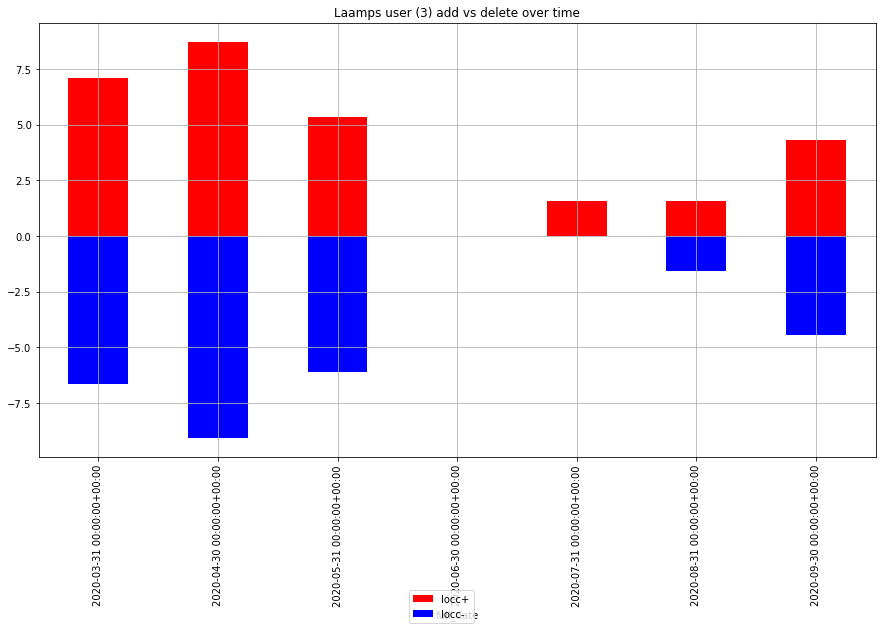

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
plot_user(project, user , ax)

In [16]:
topi_pd = sorted_people_commits(year=year, month=month)[0]
topi_pd.index = pd.to_datetime(topi_pd['full_date'])
topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum()
quarter_checkin_i

,year,month,day,doy,locc,locc+,locc-
full_date,,,,,,,
2020-01-31 00:00:00+00:00,371680,184,3105,3105,213359,21598,191761
2020-02-29 00:00:00+00:00,254520,252,2361,6267,5750,1748,4002
2020-03-31 00:00:00+00:00,321180,477,2227,11767,6899,1849,5050
2020-04-30 00:00:00+00:00,327240,648,2598,17340,319041,1737,317304
2020-05-31 00:00:00+00:00,311080,768,3036,21610,24956,23987,969
2020-06-30 00:00:00+00:00,704980,2094,5712,58760,2042383,24898,2017485
2020-07-31 00:00:00+00:00,579740,2009,3454,55688,38461,31525,6936
2020-08-31 00:00:00+00:00,614080,2431,4762,69483,18591,16773,1818
2020-09-30 00:00:00+00:00,551460,2457,3700,70312,11480,6983,4497


In [18]:
def plot_project_month(project_name, y, mo, axis):
  people_srtd = sorted_people_commits(year=y, month=mo)
  top0_pd = people_srtd[0] 
  top0_pd.index = pd.to_datetime(top0_pd['full_date'])
  top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
  daily_checkin_0 = top0_pd.groupby(pd.Grouper(freq='D')).sum()
  daily_checkin_sum =  daily_checkin_0
  for i in range(1, len(people_srtd)):
    topi_pd = sorted_people_commits(year=y, month=mo)[i] 
    topi_pd.index = pd.to_datetime(topi_pd['full_date'])
    topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
    daily_checkin_i = topi_pd.groupby(pd.Grouper(freq='D')).sum() 
    daily_checkin_sum.combine(other=daily_checkin_i, func=(lambda s1, s2 : s1 + s2), fill_value=0)
  daily_checkin_sum['locc+'] = np.log2(daily_checkin_sum['locc+']).fillna(0)
  daily_checkin_sum['locc-'] = -np.log2(daily_checkin_sum['locc-']).fillna(0)
  ax_ans = daily_checkin_sum['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  ax_ans1 = daily_checkin_sum['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
  ax_ans1.set_title(project_name + ' add vs delete in '+ str(mo) + " of" + str(y))
  handles, labels = ax_ans.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="upper right")


In [19]:
def plot_project(project_name, y, axis, mo=None):
  if mo is None: 
    people_srtd = sorted_people_commits(y)
    top0_pd = sorted_people_commits(y)[0] 
    top0_pd.index = pd.to_datetime(top0_pd['full_date'])
    top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
    quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='M')).sum()
    quarter_checkin_sum =  quarter_checkin_0
    for i in range(1, len(people_srtd)):
      topi_pd = sorted_people_commits(y)[i] 
      topi_pd.index = pd.to_datetime(topi_pd['full_date'])
      topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
      quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
      quarter_checkin_sum.combine(other=quarter_checkin_i, func=(lambda s1, s2 : s1 + s2), fill_value=0)
    quarter_checkin_sum['locc+'] = np.log2(quarter_checkin_sum['locc+'])
    quarter_checkin_sum['locc-'] = -np.log2(quarter_checkin_sum['locc-'])
    ax_ans = quarter_checkin_sum['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
    ax_ans1 = quarter_checkin_sum['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
    ax_ans1.set_title(project_name + ' add vs delete in ' + str(y))
    handles, labels = ax_ans.get_legend_handles_labels() 
    fig.legend(handles, labels, loc="upper right")
    return ax_ans1 
  else: 
    ax_ans2 = plot_project_month(project_name=project_name, y=y, mo=mo, axis=axis)
    return ax_ans2

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


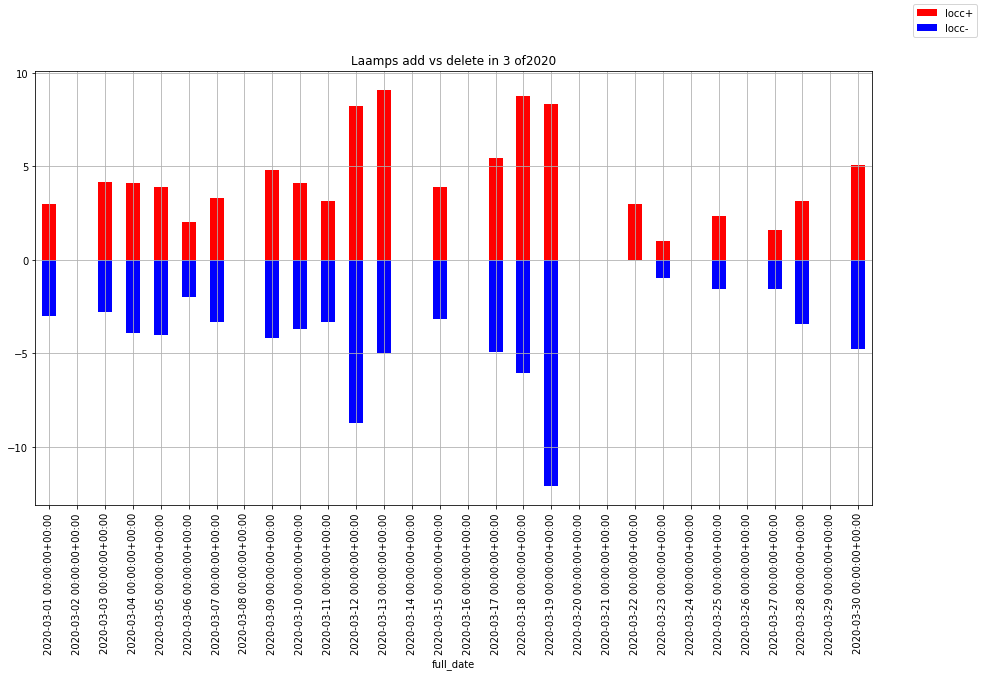

In [20]:
fig, axis = plt.subplots(figsize=(20,8))
plot_project(project_name=project, y=year, mo=3, axis=axis)

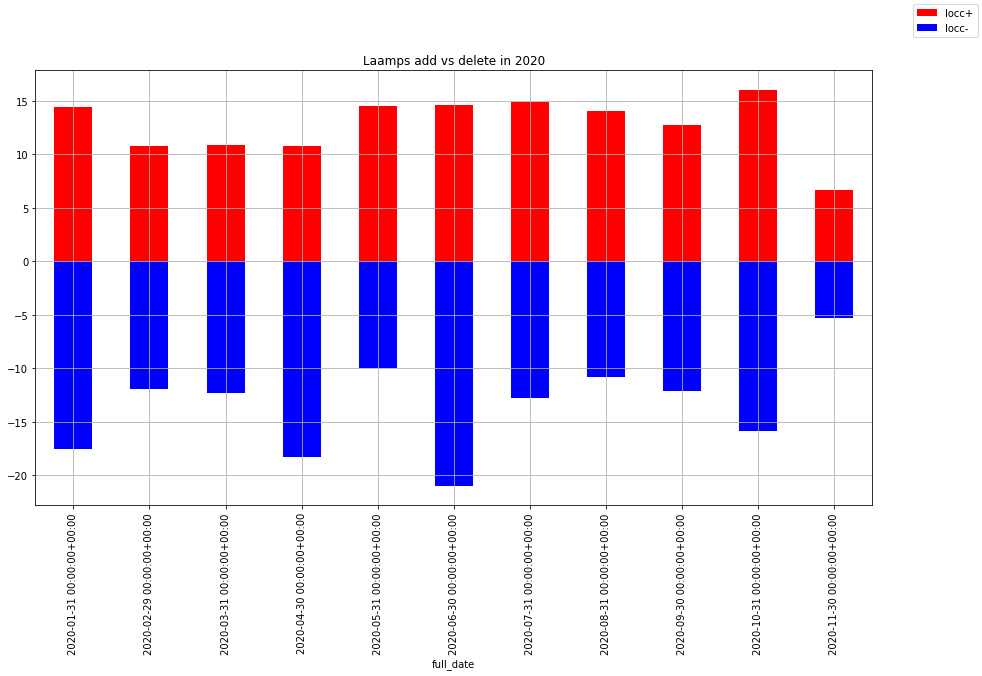

In [21]:
fig, axis = plt.subplots(figsize=(20,8))
plot_project(project, year, axis)

In [22]:
#@title Default title text
year1 = 2016 #@param [2020, 2019, 2018,2017,2016,2015] {type : "raw"} 
year2 = 2017 #@param [2020, 2019, 2018,2017,2016,2015] {type : "raw"}

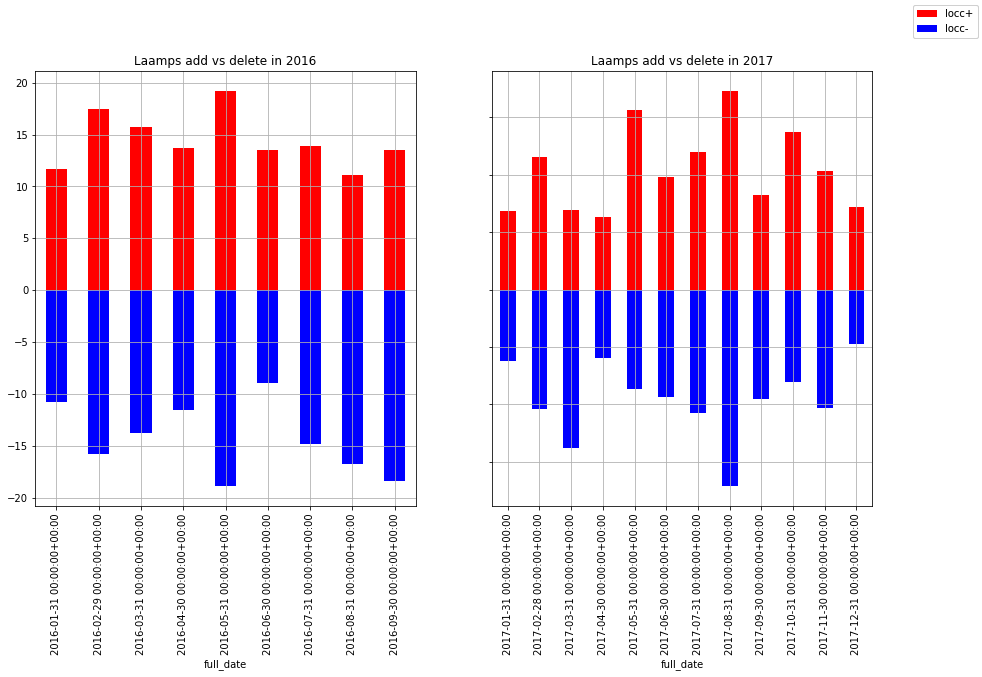

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2) 
plot_project(project, year1, ax1) 
plot_project(project, year2, ax2)

In [24]:
def plot_project_average(project_name, axis):
  year_zero = years[-1]
  people_srtd = sorted_people_commits(year_zero)  # really doesn't matter what year, as all needed is valid year to zero out.
  top0_pd = sorted_people_commits(year_zero)[0] 
  top0_pd.index = pd.to_datetime(top0_pd['full_date'])
  top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
  quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='M')).sum()
  all_avgs =  quarter_checkin_0
  num_of_years = len(years)
  for y in years[:-1]:
    people_srtd = sorted_people_commits(y)
    top0_pd = sorted_people_commits(y)[0] 
    top0_pd.index = pd.to_datetime(top0_pd['full_date'])
    top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
    quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='M')).sum()
    quarter_checkin_sum =  quarter_checkin_0
    for i in range(1, len(people_srtd)):
      topi_pd = sorted_people_commits(y)[i] 
      topi_pd.index = pd.to_datetime(topi_pd['full_date'])
      topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
      quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
      quarter_checkin_sum.combine(other=quarter_checkin_i, func=(lambda s1, s2 : (s1 + s2)/num_of_years), fill_value=0).fillna(0)
    all_avgs.combine(other=quarter_checkin_sum, func=(lambda s1, s2 : (s1 + s2)), fill_value=0).fillna(0)
  all_avgs['locc+'] = np.log2(all_avgs['locc+'])
  all_avgs['locc-'] = -np.log2(all_avgs['locc-'])
  all_avgs.index = [i.month_name() for i in list(all_avgs.index)]
  ax_ans  = all_avgs['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  ax_ans1 = all_avgs['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
  ax_ans1.set_title(project_name + ' add vs delete in the average year')
  handles, labels = ax_ans1.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="upper right")
  return all_avgs 

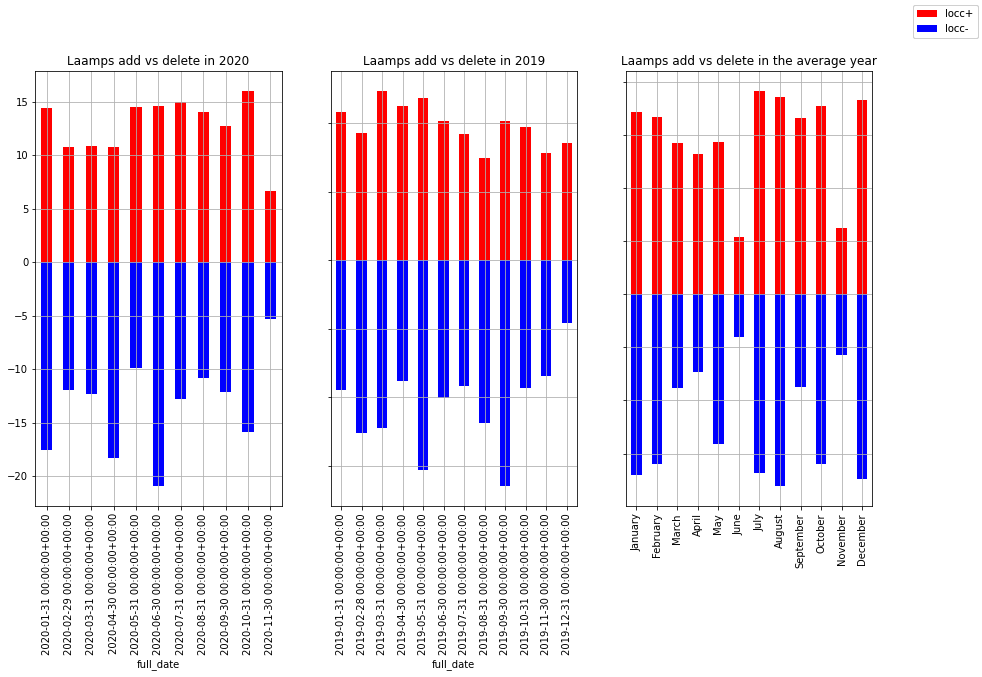

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
plot_project(project, year, ax1) 
plot_project(project, 2019, ax2)
all_avgs = plot_project_average(project, ax3)


In [26]:
def plot_project_monthly_avg(project_name, mo, axis):
  year_zero = years[-1]
  people_srtd = sorted_people_commits(year=year_zero, month=mo)  # really doesn't matter what year, as all needed is valid year to zero out.
  top0_pd = people_srtd[0] 
  top0_pd.index = pd.to_datetime(top0_pd['full_date'])
  top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
  quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='D')).sum()
  all_avgs =  quarter_checkin_0
  num_of_years = len(years)
  for y in years[:-1]:
    people_srtd = sorted_people_commits(year=y, month=mo)
    print("length of -people_srtd- in year: ", y, len(people_srtd)) 
    if len(people_srtd) > 0:
      top0_pd = people_srtd[0] 
      top0_pd.index = pd.to_datetime(top0_pd['full_date'])
      top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
      quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='D')).sum()
      quarter_checkin_sum =  quarter_checkin_0
      for i in range(1, len(people_srtd)):
        topi_pd = sorted_people_commits(year=y, month=mo)[i] 
        topi_pd.index = pd.to_datetime(topi_pd['full_date'])
        topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
        quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='D')).sum() 
        quarter_checkin_sum.combine(other=quarter_checkin_i, func=(lambda s1, s2 : (s1 + s2)/num_of_years), fill_value=0).fillna(0)
      all_avgs.combine(other=quarter_checkin_sum, func=(lambda s1, s2 : (s1 + s2)), fill_value=0).fillna(0)
  all_avgs['locc+'] = np.log2(all_avgs['locc+']).fillna(0)
  all_avgs['locc-'] = -np.log2(all_avgs['locc-']).fillna(0)
  all_avgs.index = [i.day for i in list(all_avgs.index)]
  ax_ans  = all_avgs['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  ax_ans1 = all_avgs['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
  ax_ans1.set_title(project_name + ' average add vs delete in month' + str(mo))
  handles, labels = ax_ans1.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="upper right")
  return all_avgs 

KeyboardInterrupt: ignored

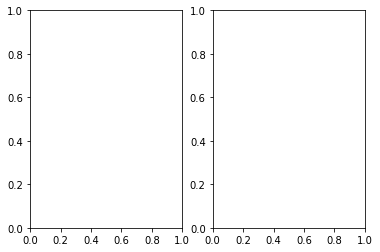

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2) 
plot_project_average(project, ax1)
plot_project_monthly_avg(project_name=project, mo=7, axis=ax2)

Showing just the difference

In [30]:
def change_year(year):
  persons = [] 
  for i in range(1):
    topi_pd = sorted_people_commits(year)[i] 
    p       = list(topi_pd['person'])[0] # using zero index for user with most commits. Can vary for different devs
    persons.append(p)
    topi_pd.index = pd.to_datetime(topi_pd['full_date'])
    topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
    quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+'])
    quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-'])
    y = quarter_checkin_i['locc+'] + quarter_checkin_i['locc-']
  
  
  x = np.arange(len(y))
  fig = plt.figure() 
  fig.set_figwidth(20) 
  fig.set_figheight(8) 
  
  plt.plot(x,y)
  z1 = np.array(y)
  z2 = np.array(0.0 * 10)
  plt.fill_between(x, y, 0,
                  where=(z1 >= z2),
                  alpha=0.30, color='green', interpolate=True, label='Positive')
  plt.fill_between(x, y, 0,
                  where=(z1 < z2),
                  alpha=0.30, color='red', interpolate=True, label='Negative')
  plt.legend()
  plt.xlabel('Month')
  plt.xticks(x, quarter_checkin_i.index, rotation='vertical')
  plt.ylabel("Net Difference in Lines of Code Changed")
  plt.title(project + " Top Contributor Add vs Delete Per Month of " + str(year));
  plt.show();

years.sort(reverse=True)
interact(change_year, year=years);

interactive(children=(Dropdown(description='year', options=(2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 20…

In [47]:
yearly_commits = lammps_sorted_commits.groupby('year').mean()
yearly_commits['total_locc'] = yearly_commits['locc+']-yearly_commits['locc-']
yearly_commits

,month,day,doy,locc,locc+,locc-,total_locc
year,,,,,,,
2006,10.443396,16.000000,302.820755,6982.792453,6852.301887,130.490566,6721.811321
2007,6.881703,14.705047,192.807571,641.659306,527.817035,113.842271,413.974763
2008,4.896617,15.054511,133.437970,352.810150,115.377820,237.432331,-122.054511
2009,7.050409,14.489101,197.810627,179.993188,161.212534,18.780654,142.431880
2010,7.207781,15.693192,203.739169,366.908046,251.770115,115.137931,136.632184
2011,6.345563,15.756826,177.494027,1166.623720,885.783276,280.840444,604.942833
2012,6.085456,14.439606,169.170912,607.516845,388.622021,218.894823,169.727198
2013,6.017520,16.073450,167.892183,1149.899596,783.710243,366.189353,417.520889
2014,5.733477,14.835489,158.109195,1932.579741,981.871408,950.708333,31.163075


Text(0, 0.5, 'Total locc')

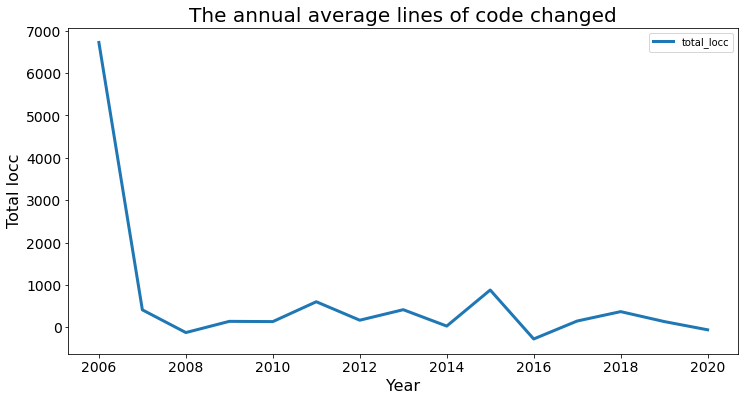

In [39]:
# colors for the line plot
#colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
#df_temperature.plot(color=colors, linewidth=3, figsize=(12,6))
yearly_commits.plot( y='total_locc',linewidth=3, figsize=(12,6))


# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(labels =['Average air temperature', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The annual average lines of code changed', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Total locc', fontsize=16)

In [37]:
# the simple moving average over a period of 3 years
yearly_commits['SMA_3'] = yearly_commits.total_locc.rolling(3, min_periods=1).mean()

# the simple moving average over a period of 5 year
yearly_commits['SMA_5'] = yearly_commits.total_locc.rolling(5, min_periods=1).mean()

# the simple moving average over a period of 10 year
yearly_commits['SMA_10'] = yearly_commits.total_locc.rolling(10, min_periods=1).mean()
yearly_commits.head()

,month,day,doy,locc,locc+,locc-,total_locc,SMA_3,SMA_5,SMA_10
year,,,,,,,,,,
2006,10.443396,16.000000,302.820755,6982.792453,6852.301887,130.490566,6721.811321,6721.811321,6721.811321,6721.811321
2007,6.881703,14.705047,192.807571,641.659306,527.817035,113.842271,413.974763,3567.893042,3567.893042,3567.893042
2008,4.896617,15.054511,133.437970,352.810150,115.377820,237.432331,-122.054511,2337.910524,2337.910524,2337.910524
2009,7.050409,14.489101,197.810627,179.993188,161.212534,18.780654,142.431880,144.784044,1789.040863,1789.040863
2010,7.207781,15.693192,203.739169,366.908046,251.770115,115.137931,136.632184,52.336518,1458.559127,1458.559127


Text(0, 0.5, 'Total locc')

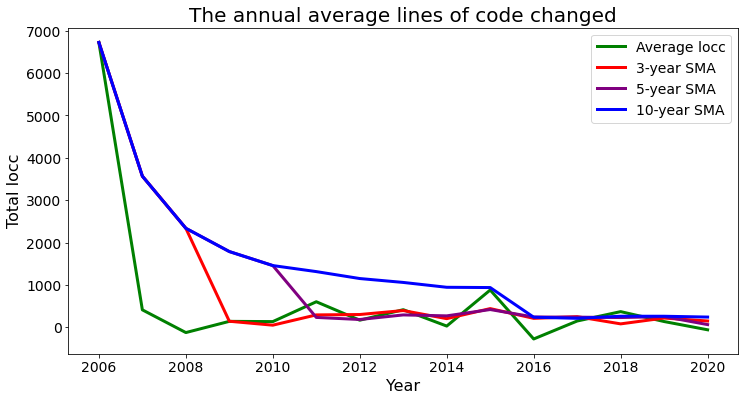

In [40]:
# colors for the line plot
colors = ['green', 'red', 'purple', 'blue']

# line plot 
yearly_commits.plot(y=['total_locc', 'SMA_3', 'SMA_5', 'SMA_10'], color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average locc', '3-year SMA', '5-year SMA', '10-year SMA'], fontsize=14)

# title and labels
plt.title('The annual average lines of code changed', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Total locc', fontsize=16)

In [62]:
lammps_sorted_commits['total_locc'] = lammps_sorted_commits['locc+']-lammps_sorted_commits['locc-']
# Group data first by year, then by month
monthly_commits = lammps_sorted_commits.groupby(["year", "month"]).mean()
monthly_commits=monthly_commits.drop(monthly_commits.index[0])
monthly_commits.head()

day         doy  ...       locc-  total_locc
year month                         ...                        
2006 10      9.400000  282.400000  ...  543.250000 -540.050000
     11     11.375000  315.375000  ...    3.656250   28.312500
     12     13.217391  347.217391  ...    3.695652    2.826087
2007 1      23.333333   23.333333  ...   48.700000  640.933333
     2      14.886792   45.886792  ...   58.622642    4.264151

[5 rows x 6 columns]

In [63]:
# the simple moving average over a period of 3 years
monthly_commits['SMA_3'] = monthly_commits.total_locc.rolling(3, min_periods=1).mean()

# the simple moving average over a period of 5 year
monthly_commits['SMA_6'] = monthly_commits.total_locc.rolling(5, min_periods=1).mean()

# the simple moving average over a period of 10 year
monthly_commits['SMA_12'] = monthly_commits.total_locc.rolling(10, min_periods=1).mean()

monthly_commits.head()

day         doy  ...       SMA_6      SMA_12
year month                         ...                        
2006 10      9.400000  282.400000  ... -540.050000 -540.050000
     11     11.375000  315.375000  ... -255.868750 -255.868750
     12     13.217391  347.217391  ... -169.637138 -169.637138
2007 1      23.333333   23.333333  ...   33.005480   33.005480
     2      14.886792   45.886792  ...   27.257214   27.257214

[5 rows x 9 columns]

Text(0, 0.5, 'Total locc')

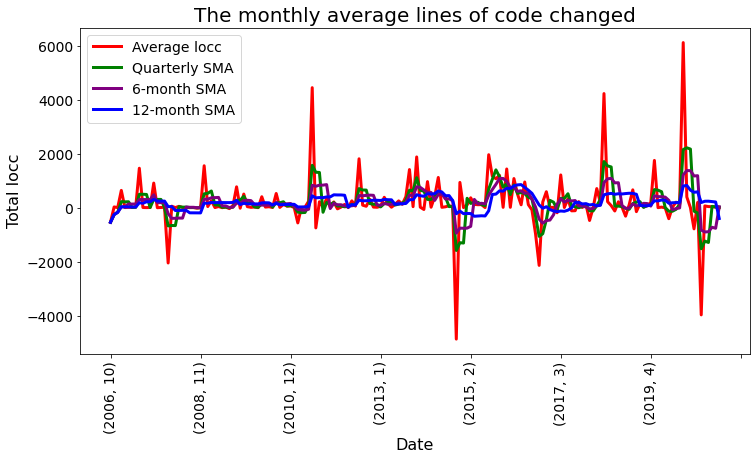

In [92]:
# colors for the line plot
colors = ['red', 'green', 'purple', 'blue']

# line plot 
monthly_commits.plot(y=['total_locc', 'SMA_3', 'SMA_6', 'SMA_12'], color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14, rotation='vertical')
plt.yticks(fontsize=14)
plt.legend(labels =['Average locc', 'Quarterly SMA', '6-month SMA', '12-month SMA'], fontsize=14)

# title and labels
plt.title('The monthly average lines of code changed', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total locc', fontsize=16)

In [85]:
idx = pd.IndexSlice
monthly = monthly_commits.loc[idx[year, :], :]
monthly

day         doy  ...       SMA_6      SMA_12
year month                         ...                        
2007 1      23.333333   23.333333  ...   33.005480   33.005480
     2      14.886792   45.886792  ...   27.257214   27.257214
     3      16.629630   75.629630  ...  138.222770   25.177308
     4      16.774648  106.774648  ...  134.022242   22.624815
     5      14.833333  134.833333  ...  137.857024   22.546714
     6      20.552632  171.552632  ...  302.172989  182.542985
     7       7.341463  188.341463  ...  302.583574  164.920394
     8      12.500000  224.500000  ...  300.149757  219.186263
     9      15.913043  258.913043  ...  300.148655  217.085448
     10     11.584507  284.584507  ...  478.134570  307.995797
     11     15.408163  319.408163  ...  185.301327  243.737158
     12      9.810811  343.810811  ...  185.735209  244.159391

[12 rows x 9 columns]

In [91]:
def change_year(year):
  persons = [] 
  for i in range(1):
    topi_pd = sorted_people_commits(year)[i] 
    p       = list(topi_pd['person'])[0] # using zero index for user with most commits. Can vary for different devs
    persons.append(p)
    topi_pd.index = pd.to_datetime(topi_pd['full_date'])
    topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
    quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+'])
    quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-'])
    y = quarter_checkin_i['locc+'] + quarter_checkin_i['locc-']
  
  
  x = np.arange(len(y))
  fig = plt.figure() 
  fig.set_figwidth(20) 
  fig.set_figheight(8) 
  
  plt.plot(x,y)
  z1 = np.array(y)
  z2 = np.array(0.0 * 10)
  plt.fill_between(x, y, 0,
                  where=(z1 >= z2),
                  alpha=0.30, color='green', interpolate=True, label='Positive')
  plt.fill_between(x, y, 0,
                  where=(z1 < z2),
                  alpha=0.30, color='red', interpolate=True, label='Negative')
  plt.legend()
  plt.xlabel('Month')
  plt.xticks(x, quarter_checkin_i.index, rotation='vertical')
  plt.ylabel("Net Difference in Lines of Code Changed")
  plt.title(project + " Top Contributor Add vs Delete Per Month of " + str(year));
  idx = pd.IndexSlice
  monthly = monthly_commits.loc[idx[year, :], :]
  #plt.plot(x, monthly['total_locc'] )
  plt.show();

years.sort(reverse=True)
interact(change_year, year=years);

interactive(children=(Dropdown(description='year', options=(2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 20…

In [42]:
import plotly.express as px
persons = [] 
for i in range(1):
  topi_pd = sorted_people_commits(year)[i] 
  p       = list(topi_pd['person'])[0] # using zero index for user with most commits. Can vary for different devs
  persons.append(p)
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
  quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+'])
  quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-'])
  quarter_checkin_i['locc total'] = quarter_checkin_i['locc+'] + quarter_checkin_i['locc-']

print(topi_pd)
fig = px.line(quarter_checkin_i, x=quarter_checkin_i.index, y=quarter_checkin_i['locc total'])
fig.show()

                           year  ...                                          sha
full_date                        ...                                             
2007-01-10 16:11:31+00:00  2007  ...  b'dfa6e4ab41276d67f52a1aa447ff16f8fe7297f9'
2007-01-10 16:10:27+00:00  2007  ...  b'4c58c011acb72670ca0359e9291f36ff786648ce'
2007-01-10 16:09:24+00:00  2007  ...  b'f9a048e353fa0e104f91fede4fa45082b7d45809'
2007-01-11 15:14:07+00:00  2007  ...  b'2b2eef73108c695e6958d9589034afece1a29194'
2007-01-12 16:00:28+00:00  2007  ...  b'9c9503082725c26c20b1499ca734044ac88e1b9d'
...                         ...  ...                                          ...
2007-12-18 16:42:57+00:00  2007  ...  b'75fefd8e37f4563c0d16efe64bc231dbdb1c2241'
2007-12-19 17:20:18+00:00  2007  ...  b'399928b9afbf2aa7453af8ff7f7e283f69fd75eb'
2007-12-19 17:20:01+00:00  2007  ...  b'985dad557939478877b41cd447eb72a0a3285be7'
2007-12-19 17:19:53+00:00  2007  ...  b'1d4e2aaaa5e7d34a9c2a59f1cfd627ee450a2b97'
2007-12-21 15:05

We can see that, at some point, the lead developer perhaps left the project, and two leads took over.

Another way to answer the above question of how much each user is contributing to the overall project (and observed over time, whether they are experiencing high churn levels) is to ask by what proportion each user is accessing each file (later we will extend this to functions). 

To do this, we assign a vector, whose length equals the total number of developers, to each file in the repo---each developer gets assigned an index in the vector. Then, as we walk through commits in a given time window, we increment the commit's author in the vector, for every file involved in the commit. 

This is explored next: 

In [ ]:
def all_files(year=None):
  """return list of (file, count) tuples sorted by count

  param  : year as time window 
  """
  ppl_commits = sorted_people_commits(year)
  seen = {}
  for i in range(len(ppl_commits)):
    df = ppl_commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for l_file in file_lists:
      for file in l_file:
        try:
          seen[file] += 1
        except KeyError:
          seen[file] = 1 
  seen_sorted = sorted(seen.items(), key=lambda x : x[1], reverse=True)
  return seen_sorted

In [ ]:
def make_indices(year=None, sorted=True):
  """return {file : file_rank}
     , {person : person_rank}
     , list of (file, count) tuples sorted by count
     , list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows.

  param  : year as time window  
  """
  files   = all_files(year)
  commits = sorted_people_commits(year, sorted)
  f_index_year = {u[0] : files.index(u) for u in files}
  ppl_index_year = {list(commits[i]['person'])[0] : i for i in range(len(commits))}
  return f_index_year, ppl_index_year, files, commits

In [ ]:
def make_user_file_mat(year=None, sorted=True):
  """return {file : file_rank}
     , {person : person_rank}

  param : year as time window
  """
  f_index, ppl_index, files, commits = make_indices(year, sorted)
  file_user_mat = [[0 for i in ppl_index] for f in f_index] 
  for i in range(len(commits)):
    df = commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for file_l in file_lists:
      for f in file_l:
        if f in f_index:
          file_user_mat[f_index[f]][ppl_index[list(df['person'])[0]]] += 1
  return f_index, ppl_index, file_user_mat

In [ ]:
def make_pandas_df(year=None, dims=None, rev=False, sorted=True):
  f_index, ppl_index, file_user_mat = make_user_file_mat(year, sorted)
  if dims is None: 
    index_labels  = list(f_index.keys()) 
    column_labels = list(ppl_index.keys()) 
  else: 
    rows = dims[0]
    cols = dims[1]
    if not rev: 
      index_labels  = list(f_index.keys())[:rows]
      column_labels = list(ppl_index.keys())[:cols]
      file_user_mat = [r[:cols] for r in file_user_mat[:rows]]
    else:
      index_labels  = list(f_index.keys())[-rows:]
      column_labels = list(ppl_index.keys())[-cols:]
      file_user_mat = [r[-cols:] for r in file_user_mat[-rows:]] 
  to_return = pd.DataFrame.from_records(file_user_mat, index=index_labels, columns=column_labels)
  return to_return

In [ ]:
#@title You can choose dimensions for your heatmaps. 
height =  7#@param {type: "raw"} 
width  = 10 #@param {type: "raw"}

In [ ]:
# make a pandas df of top height users and top width files
mat_df_all_10 = make_pandas_df(dims=(height,width))

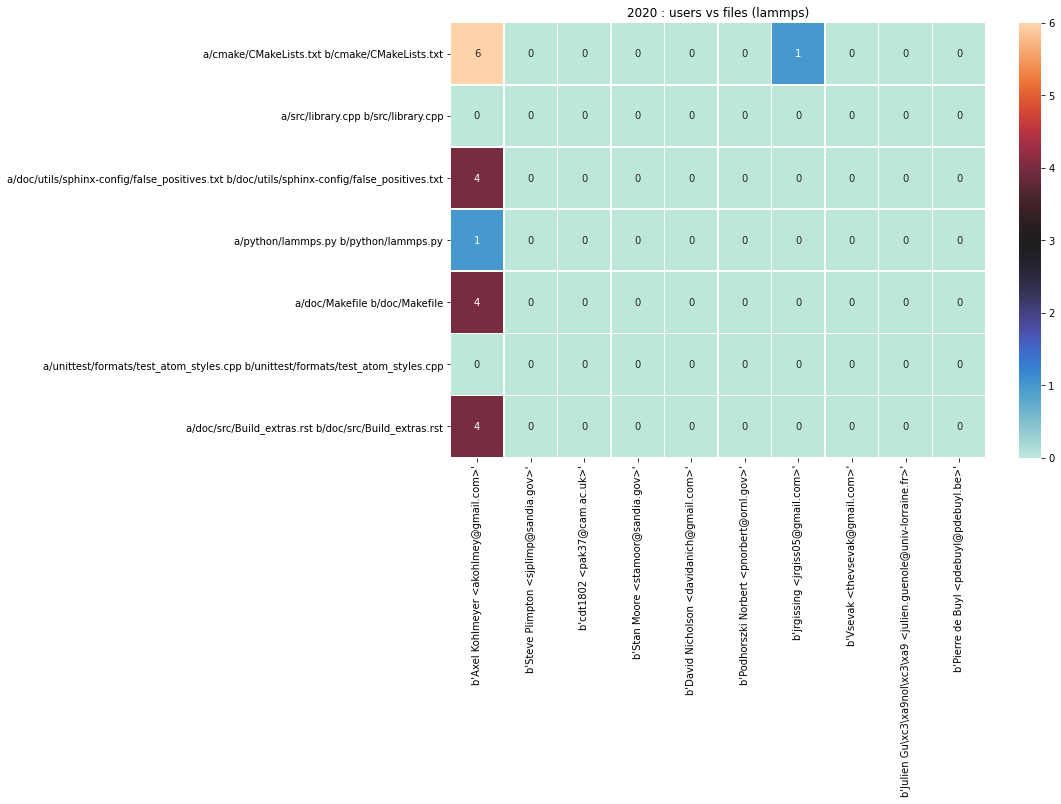

<function __main__.make_map>

In [ ]:
def make_map(curr_year): 
  fig, ax = plt.subplots(figsize=(12,8))
  frame_df   = make_pandas_df(year=curr_year, dims=(height,width))
  frame_ret  = sb.heatmap(frame_df, annot=True, linewidths=.5, cmap='icefire')
  plt.title(str(curr_year) + " : users vs files (lammps)") 
  plt.show() 

interact(make_map, curr_year=years)

Consequently, we can get a better idea of just how much of an impact each developer has on the project, by considering which types of files they access, and how often. 

The above applies for a single individual, and can help diagnose months of reduced activity. However, what if a team leader wanted a picture of how well all of their team is performing? In particular, we we want to know by how much each user is contributing to the project. 

One way to answer this question, is to visualize each user's contributions per business quarter, over time, and observe the trends. For example, below we show the trends in contributions of the top 3 users with the most commits:

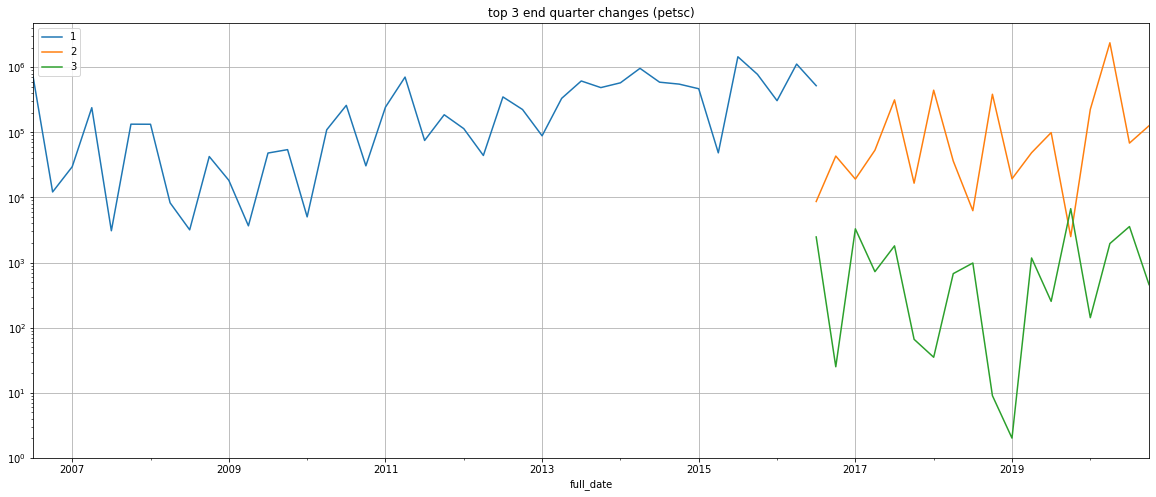

In [ ]:
fig, ax = plt.subplots() 
persons = [] 
for i in range(3):
  topi_pd = sorted_people_commits()[i]
  p       = list(topi_pd['person'])[0]
  persons.append(p)
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='Q')).sum() 
  quarter_checkin_i['locc'].plot(figsize=(20,8), grid=True, ax=ax, logy=True)
ax.set_title('top 3 end quarter changes (petsc)')
ax.legend(list(map(lambda x : x + 1, list(range(len(persons))))));



---



---



But the file level seems too big for an analysis of this kind. For example, one could increase their contribution by adding nothing but comments into their source script (not to say commenting code isn't good practice)

To remedy this, we want to go lower than file level, and explore changes made to *functions* instead. That is, the goal is to produce a heatmap such as the above, but with functions instead of files on the y-axis.

To do this, we bring in a callgraph for the repository (root as the source directory). Since each node in the graph is a function name, we go through the commit history, and scan the commit's patch for the node (function match). If a match is found, the commit's author's index is incremeted in the function's vector of modifiers (much like we did with files).

We explore this analysis below:

In [ ]:
!pip install networkx

In [ ]:
!pip install pydot 

In [ ]:
!pip install graphviz 

In [ ]:
import networkx as nx

In [ ]:
from networkx.drawing.nx_pydot import from_pydot, read_dot

In [ ]:
!head -20  '/content/ideas-uo/data/high_churn_data/callgraph.dot'

digraph "Call graph" {
	label="Call graph";

	Node0x56158efce930 [shape=record,label="{external node}"];
	Node0x56158efce930 -> Node0x56158b6cd7c0;
	Node0x56158efce930 -> Node0x5615883943f0;
	Node0x56158efce930 -> Node0x56158aab21f0;
	Node0x56158efce930 -> Node0x5615936cac40;
	Node0x56158efce930 -> Node0x56158bcceaa0;
	Node0x56158efce930 -> Node0x56158da464a0;
	Node0x56158efce930 -> Node0x56158eb3b5b0;
	Node0x56158efce930 -> Node0x56158b6c8f20;
	Node0x56158efce930 -> Node0x5615918aa810;
	Node0x56158efce930 -> Node0x56158ed1ca80;
	Node0x56158efce930 -> Node0x5615883cdb90;
	Node0x56158efce930 -> Node0x56158bb6dd70;
	Node0x56158efce930 -> Node0x5615883c9650;
	Node0x56158efce930 -> Node0x56158daa37c0;
	Node0x56158efce930 -> Node0x561588393090;
	Node0x56158efce930 -> Node0x5615885b1830;


In [ ]:
!head -20 '/content/ideas-uo/data/high_churn_data/lamps_unmangle.dot'

Printing analysis 'Print call graph to 'dot' file':
Pass::print not implemented for pass: 'Print call graph to 'dot' file'!
digraph "Call graph" {
	label="Call graph";
	Node0x5557e11f2030 [shape=record,label="{LAMMPS_NS::AtomVecSphere::~AtomVecSphere()}"];
	Node0x5557e11f2030 -> Node0x5557ea788de0;
	Node0x5557e5a263d0 [shape=record,label="{LAMMPS_NS::AtomVecSphere::~AtomVecSphere()}"];
	Node0x5557e5a263d0 -> Node0x5557e11f2030;
	Node0x5557e5a263d0 -> Node0x5557eace3590;
	Node0x5557eafc62b0 [shape=record,label="{LAMMPS_NS::AtomVecSphere::process_args(int, char**)}"];
	Node0x5557eafc62b0 -> Node0x5557e828c800;
	Node0x5557eafc62b0 -> Node0x5557e7466cd0;
	Node0x5557eafc62b0 -> Node0x5557e828c800;
	Node0x5557eafc62b0 -> Node0x5557e7466cd0;
	Node0x5557eafc62b0 -> Node0x5557e0347550;
	Node0x5557eafc62b0 -> Node0x5557e61b60f0;
	Node0x5557eafc62b0 -> Node0x5557e0357070;
	Node0x5557eafc62b0 -> Node0x5557e61b60f0;
	Node0x5557eafc62b0 -> Node0x5557e0357070;
	Node0x5557eafc62b0 -> Node0x5557e060b3c

In [ ]:
str_r = ''.join(open('/content/ideas-uo/data/high_churn_data/lamps_unmangle.dot', 'r').readlines()[2:])

In [ ]:
unmangled_f = open('/content/ideas-uo/data/high_churn_data/clean_unmangle.dot', 'w')
unmangled_f.write(str_r)

4636355

In [ ]:
# create dictionary of hashed names to label names 
import re 
split_str = str_r.split(';')
label_lines = [l.strip() for l in split_str[1:] if 'label' in l]
hash_to_actual = {}
count = 0
for line in label_lines: 
  line_l     = line.split(' ')
  node_hash  = line_l[0]
  label_info = line_l[1]
  node_name  = label_info.split(',')[1].split('=')[-1][:-1] if label_info.split(',')[1].split('=')[-1][-1] == ']' else label_info.split(',')[1].split('=')[-1]
  hash_to_actual[node_hash] = node_name

In [ ]:
# import this as a nx graph 
G = nx.Graph(read_dot('/content/ideas-uo/data/high_churn_data/clean_unmangle.dot'))

Let's look at how many nodes we have in G

In [ ]:
from networkx.classes.function import info  
print(info(G))

Name: Call graph
Type: Graph
Number of nodes: 7256
Number of edges: 22650
Average degree:   6.2431


We can attempt a visual of the callgraph

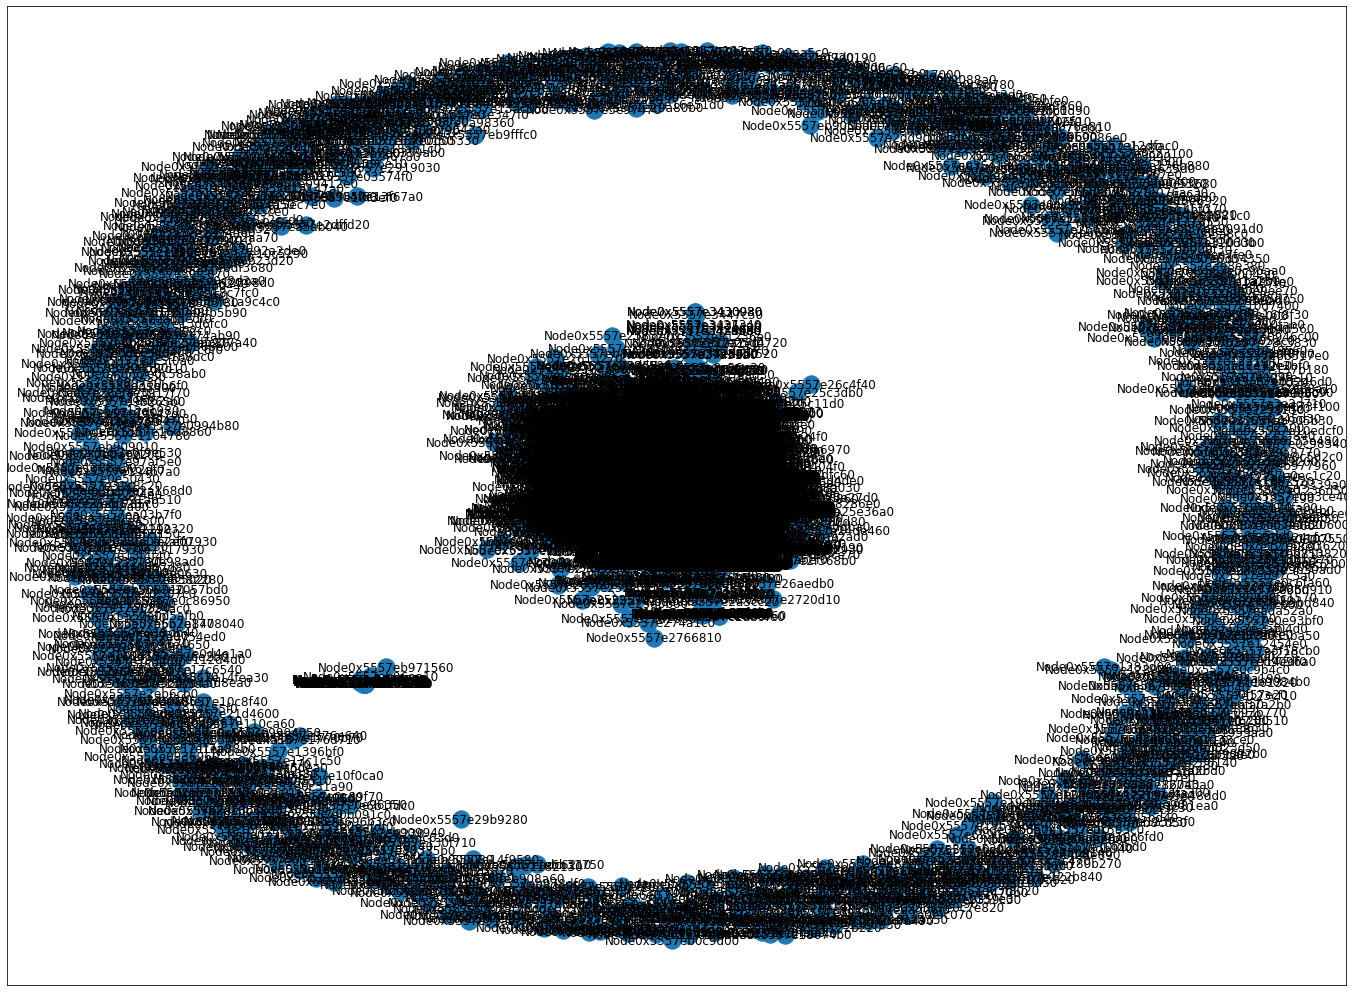

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(24,18))
nx.draw_networkx(G, ax=ax)

What a mess! 

Instead of the whole graph, We can get a sense of what the most important functions are, and how they interact, by looking at the **K-Core** of the callgraph. A K-core is a maximal subgraph that contains nodes of degree k or more. The main core, is the k-core with largest degree k. 

In [ ]:
from networkx.algorithms.core import *
G.remove_edges_from(nx.selfloop_edges(G)) # graphs with self loops are not permitted by this operation
G_kcore = k_core(G)

In [ ]:
print(info(G_kcore))

Name: Call graph
Type: Graph
Number of nodes: 99
Number of edges: 1192
Average degree:  24.0808


Notice the average node degree increase 4x!

Visualize the K-core

In [ ]:
import matplotlib.pyplot as plt

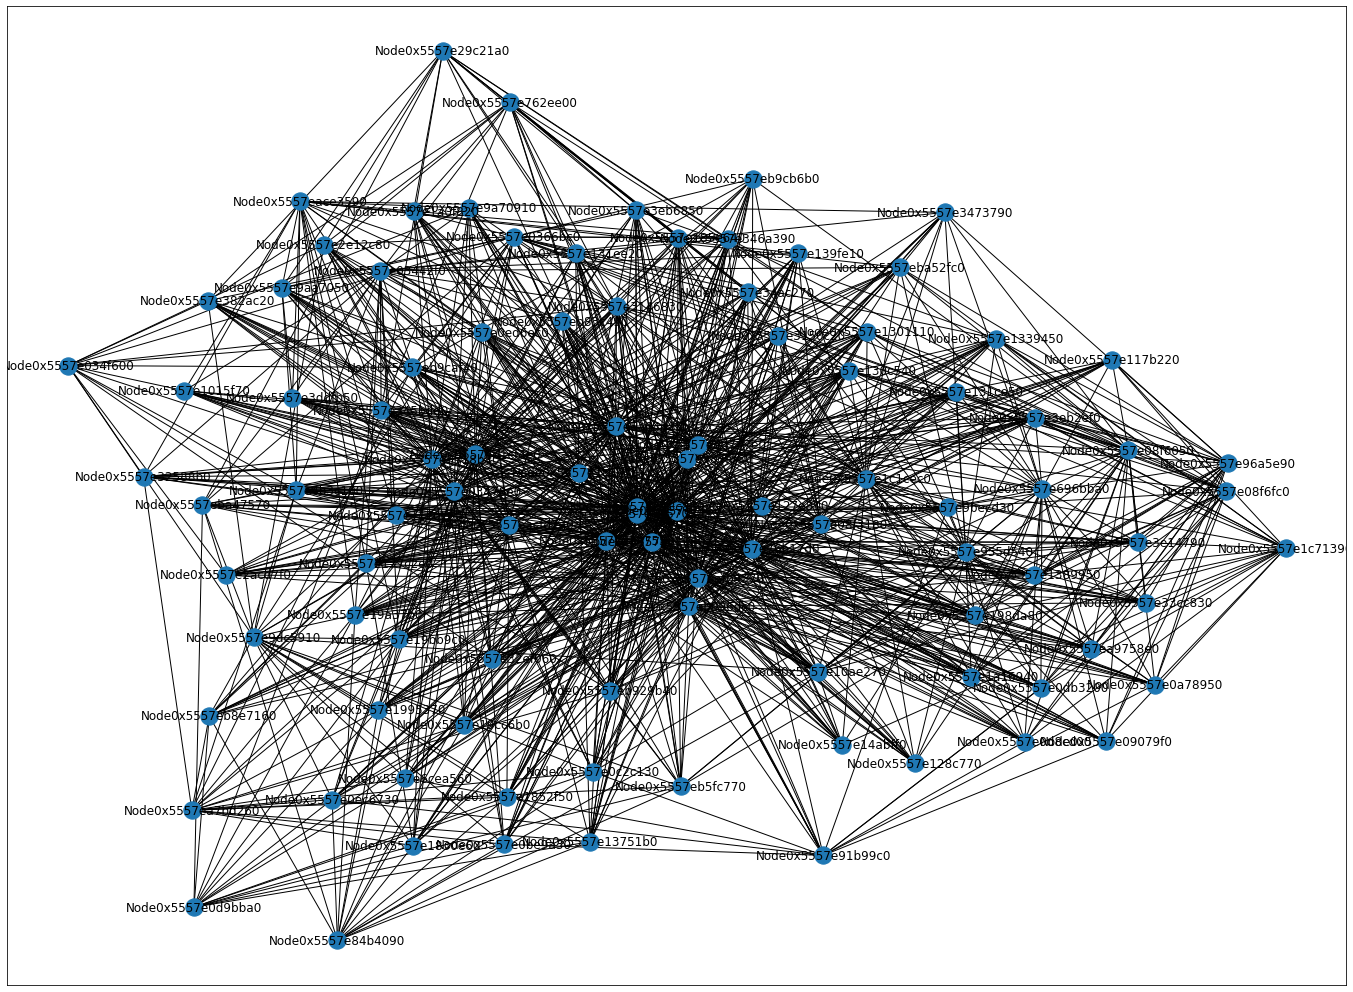

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(24,18))
nx.draw_networkx(G_kcore, ax=ax)

Much Cooler! **Note:** would be even cooler if nodes could be dragged and dropped around

**Note: ** we can recover the K in K-core and unhash any of the nodes names if we wanted to:

In [ ]:
#k in k-core
d = core_number(G_kcore)

In [ ]:
print(d)

{'Node0x5557e6718b40': 15, 'Node0x5557e3146830': 15, 'Node0x5557eb9cb6b0': 15, 'Node0x5557e130c540': 15, 'Node0x5557e0347550': 15, 'Node0x5557e9aa7050': 15, 'Node0x5557e1c0b7c0': 15, 'Node0x5557e96a5e90': 15, 'Node0x5557eba52fc0': 15, 'Node0x5557e9dc5910': 15, 'Node0x5557e0c2c130': 15, 'Node0x5557e987f350': 15, 'Node0x5557e345bdd0': 15, 'Node0x5557eb9caf40': 15, 'Node0x5557e1389950': 15, 'Node0x5557e08f6fc0': 15, 'Node0x5557e0be9a30': 15, 'Node0x5557e19a37b0': 15, 'Node0x5557e10ae270': 15, 'Node0x5557eba47570': 15, 'Node0x5557e828c800': 15, 'Node0x5557ead747e0': 15, 'Node0x5557e09079f0': 15, 'Node0x5557e32ef060': 15, 'Node0x5557e0357070': 15, 'Node0x5557e84b4090': 15, 'Node0x5557e0ed6ec0': 15, 'Node0x5557e139fe10': 15, 'Node0x5557e2e12c80': 15, 'Node0x5557eacfd7a0': 15, 'Node0x5557eb83c490': 15, 'Node0x5557e955d540': 15, 'Node0x5557eafb9570': 15, 'Node0x5557e0d9bba0': 15, 'Node0x5557e9a70910': 15, 'Node0x5557eb096dc0': 15, 'Node0x5557e382ac20': 15, 'Node0x5557e1301110': 15, 'Node0x5557

Thus, we can conclude that the maximal core we obtained is a 15-core. Since our nodes are functions, and an edge between nodes represents a function call, what we have obtained is a maximal subset of our functions in which function call at least 15 other functions. 

In [ ]:
# unhash names
d_unhashed = {}
for k, v in d.items():
  if k in hash_to_actual.keys(): 
    d_unhashed[hash_to_actual[k]] = v 
  else:
    continue 
d_unhashed

{'"{LAMMPS_NS::Balance::command(int': 15,
 '"{LAMMPS_NS::Balance::options(int': 15,
 '"{LAMMPS_NS::Bond::write_file(int': 15,
 '"{LAMMPS_NS::ChangeBox::command(int': 15,
 '"{LAMMPS_NS::Compute::Compute(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeChunkAtom::ComputeChunkAtom(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeChunkAtom::init()}"': 15,
 '"{LAMMPS_NS::ComputeChunkSpreadAtom::ComputeChunkSpreadAtom(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeDisplaceAtom::ComputeDisplaceAtom(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeGlobalAtom::ComputeGlobalAtom(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeMSD::ComputeMSD(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeMSDChunk::ComputeMSDChunk(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeReduce::ComputeReduce(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeReduceChunk::ComputeReduceChunk(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeSlice::ComputeSlice(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeVACF::ComputeVACF(LAMMPS_NS::LAM

Below, we associate functions in the callgraph with their developers (by searching for function name in commit patches as mentioned above)

In [ ]:
!git clone https://github.com/lammps/lammps.git

Cloning into 'lammps'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 244635 (delta 68), reused 53 (delta 28), pack-reused 244471
Receiving objects: 100% (244635/244635), 501.13 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (205570/205570), done.
Checking out files: 100% (10912/10912), done.


In [ ]:
!ls 

drive  ideas-uo  lammps  sample_data


In [ ]:
cd lammps/

/content/lammps


In [ ]:
#89842fc7c443b48c431aa305d83d7b69319e1bd2' #this is the sha used to generate the callgraph

In [ ]:
!git reset --hard 89842fc7c443b48c431aa305d83d7b69319e1bd2

HEAD is now at 89842fc7c Merge pull request #2418 from akohlmey/collected-small-changes


In [ ]:
!mkdir temp

In [ ]:
!git log -5000 > temp/logShas5000.txt

In [ ]:
!head -30 temp/logShas5000.txt

commit 89842fc7c443b48c431aa305d83d7b69319e1bd2
Merge: 28641bcbc 61c33e562
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 17:45:10 2020 -0400

    Merge pull request #2418 from akohlmey/collected-small-changes
    
    Collected small changes and bugfixes for the stable release

commit 28641bcbc7cc4ace6132a17ccc20d0571cac9a4b
Merge: d27c7cd2f 67803fe17
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 17:18:02 2020 -0400

    Merge pull request #2402 from ndtrung81/gpu-dpd
    
    Allowed dpd/tstat/gpu and dpd/gpu to work together in pair style hybrid

commit 61c33e5622b19229964497a2677446c8cbf900e8
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 16:58:08 2020 -0400

    update documentation conventions for recent changes to the manual.

commit 3926cbe5f0dcf55ff41ac943a9fd82753465d6d2
Merge: 865b159d1 45939602a
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 15:18:03 2020 -0400

    Merge branch 'patch-3' of github.com:evoyiat

In [ ]:
with open('temp/logShas5000.txt', 'r') as logfile: 
  shas = []
  count = 0
  for line in logfile.readlines(): 
    line_l = line.strip().split() 
    if isinstance(line_l, list):
      if len(line_l) >= 2 and (line_l[0] == 'commit'): 
        shas.append(line_l[1])

Below, one can sign in usign their github password, but that is soon to be deprecated in preference of authorization tokens. Which, once inside one's account, can be generated as shown [here](https://docs.github.com/en/free-pro-team@latest/github/authenticating-to-github/creating-a-personal-access-token)

In [ ]:
import requests 
import getpass 
resp_json = None 
OK = 200 
username = input("Username: ") 
password = getpass.getpass(prompt='Auth Token: ', stream=None)
AUTH = (username, password)
commit_objs = [] 
count = 0 
for sha in shas: 
  url = 'https://api.github.com/repos/lammps/lammps/commits/' + sha        
  resp = requests.get(url, auth=AUTH) 
  if resp.status_code != OK:
    print(resp.status_code)
  else:
    commit_objs.append(resp.json())
  count += 1
  if count % 500 == 0: 
    print(url)

KeyboardInterrupt: ignored

In [ ]:
test_fnames = [e[1:] for e in list(hash_to_actual.values())]
# test_fnames
test_f_not_lammps = [e for e in test_fnames if '{LAMMPS_NS::' not in e] 
test_f_lammps = [e[len('{LAMMPS_NS::'):] for e in test_fnames if '{LAMMPS_NS' in e]

In [ ]:
tests_fnames = test_f_lammps + test_f_not_lammps

Some data clean up

In [ ]:
import copy 
new_test_fnames = []
for name in tests_fnames:
  last_char = name[-1]
  if last_char == "}":
    new_test_fnames.append(name[:-1])
  elif last_char == '"':
    if name[-2] == '}':
      new_test_fnames.append(name[:-2])
    else: 
      new_test_fnames.append(name[:-1])
  else:
    new_test_fnames.append(name)
tests_fnames = copy.deepcopy(new_test_fnames)
tests_fnames = [f.split('(')[0] for f in tests_fnames] # Assume that no two functions of the same `name` in our call graph take arguments of the same type. 

In [ ]:
import re  
def find_func_commiter(f_name, patch_obj, commit_obj):
  func_committer = None 
  for obj in patch_obj: 
    if f_name in obj: 
      func_committer = commit_obj['commit']['committer']['name']
  return func_committer

In [ ]:
black_list = ['int)', '{', '{atof', '{double', '{exp', '{write', '{printf']
functions_dict = {}
max_user_count = 0 
user_count = 0 
users_dict = {} 
for name in tests_fnames: 
  if name in black_list: 
    continue 
  for obj in commit_objs: 
    obj_files   = obj['files'] 
    try:
      obj_patches = [e['patch'] for e in obj_files if e['filename'][-4:] == '.cpp']
    except KeyError:
      continue 
    f_committer = find_func_commiter(name, obj_patches, obj) 
    if isinstance(f_committer, str): 
      if name in functions_dict.keys(): 
        functions_dict[name].append(f_committer) 
      else: 
        functions_dict[name] = [f_committer] 
      if f_committer in users_dict: 
        continue 
      else: 
        users_dict[f_committer] = user_count 
        user_count += 1 

In [ ]:
1 + max(users_dict.values()) == len(users_dict.keys()) 

Thus, using 5000 commits in the past, we can associate 1300 out of 7256 functions in the callgraph with developers. 

Let's see how many functions in our core graph we have annotated: 

In [ ]:
count = 0 
core_funcs = {} 
for n in functions_dict.keys(): 
  for s in d_unhashed: 
    if n in s: 
      core_funcs[n] = functions_dict[n]
      count += 1 
count

This is 2/3 of functions in our core callgraph. 

Now, using **functions_dict** and **users_dict** we should be able to generate an pandas dataframe of functions and users, which we can later use to generate a heatmap. 

In [ ]:
f_vectors = {f : [0 for i in range(len(users_dict.keys()))] for f in functions_dict}

In [ ]:
for fname in functions_dict: 
  fusers        = functions_dict[fname] 
  fusers_counts = {u : fusers.count(u) for u in fusers} 
  for u in fusers_counts.keys(): 
    f_vectors[fname][users_dict[u]] = fusers_counts[u]

In [ ]:
index_col = [0 for i in range(len(users_dict.keys()))]
for i in range(len(users_dict.keys())): 
  for u in users_dict.keys(): 
    if users_dict[u] == i : 
      index_col[i] = u 

In [ ]:
new_col = {'index' : index_col}
f_vectors.update(new_col)

In [ ]:
df = pd.DataFrame.from_dict(f_vectors)

In [ ]:
df = df.set_index('index')

Grab a slice of the first alphabetical functions to plot with the top 10 users

In [ ]:
top_df = df.head(10).loc[:, 'AtomVecSphere::process_args':'AtomVec::size_restart']

In [ ]:
plot(top_df, 'users vs functions (lammps)')

And thus, we have achieved our goal of storing function data, instead of files, in the heatmap. 